## Circuit constructions

This notebook demonstrates the following functions of ``pygrnd.qc.circuitConstructor`` in Pygrnd:
- ``decomposer``: decompose a general unitary gate into uncontrolled and controlled 1-qubit gates
- ``circuitStateVector``: construct a circuit for the preparation of a state vector 
- ``controlledXGateToffoliDecomposition``: decompose an X gate with many control qubits into Toffoli gates with linear overhead

The methods are implementations or variations of algorithms of the following paper: 
A. Barenco, C. Bennett, R. Cleve, D. DiVincenzo, N. Margolus, P. Shor, T. Sleator, J. Smolin, H. Weinfurter: "Elementary gates for quantum computation", Physical Review A52, 3457 (1995).

In [14]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister # Aer, execute
#from qiskit.extensions import UnitaryGate

from qiskit.quantum_info import Statevector, Operator
from qiskit.providers.basic_provider import BasicProvider

import numpy as np
import math
import random
import pygrnd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pygrnd.qc.circuitConstructor import *

#### Decomposition of $X\otimes X$
- we generate a circuit for the unitary $X \otimes X$ on 2 qubits
- the algorithm decomposes the unitary without analyzing the structure
- calculate the norm of the difference between the original unitary and the unitary of the constructed circuit

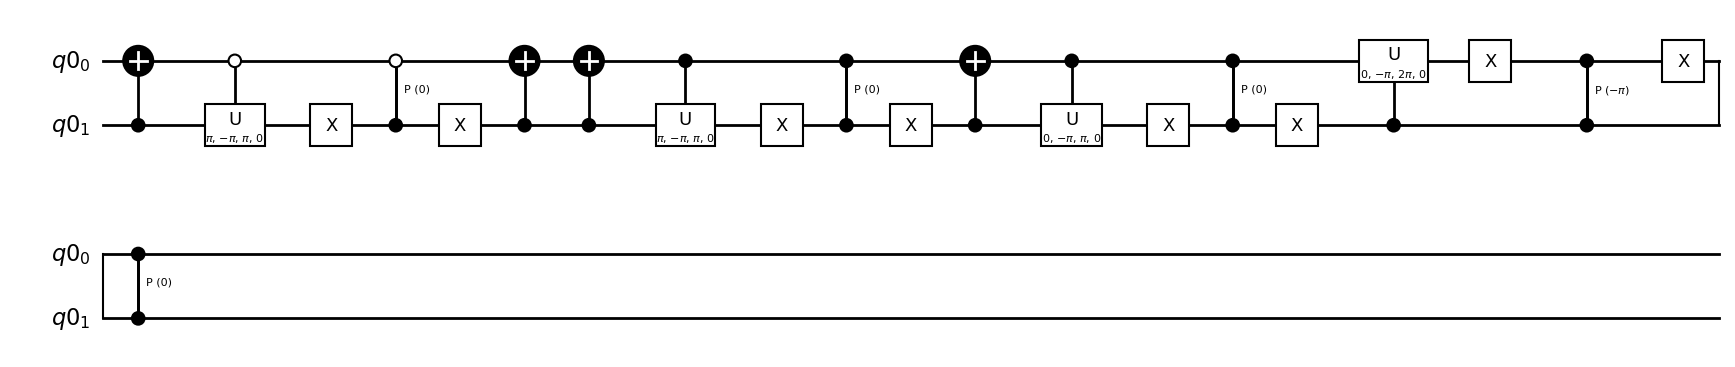

In [2]:
XX=np.array([[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])

qr=QuantumRegister(2)
qc=QuantumCircuit(qr)
decomposer(XX, qc, qr)
qc.draw(output='mpl', style="bw")

In [3]:
#backend = Aer.get_backend('unitary_simulator')
#job = execute(qc, backend)
#u = np.asarray(job.result().get_unitary())
#print("Frobenius norm of difference between given unitary and result:",np.linalg.norm(XX-u))

from qiskit.quantum_info import Statevector, Operator
from qiskit.providers.basic_provider import BasicProvider

u = Operator(qc).data


#### Decomposition of $F_3 \oplus I_1$
- implement the $3x3$ Fourier transform $F_3$ on two qubits
- use the basis states $|00\rangle$, $|01\rangle$ and $|10\rangle$ and identity on $|11\rangle$

In [4]:
f3i1=np.zeros((4,4),dtype=complex)
w3=np.exp(-2*math.pi*1j/3)
for i in range(3):
    for j in range(3):
        f3i1[i][j]=w3**(i*j)/math.sqrt(3)
f3i1[3][3]=1
print(f3i1)

[[ 0.57735027+0.j   0.57735027+0.j   0.57735027+0.j   0.        +0.j ]
 [ 0.57735027+0.j  -0.28867513-0.5j -0.28867513+0.5j  0.        +0.j ]
 [ 0.57735027+0.j  -0.28867513+0.5j -0.28867513-0.5j  0.        +0.j ]
 [ 0.        +0.j   0.        +0.j   0.        +0.j   1.        +0.j ]]


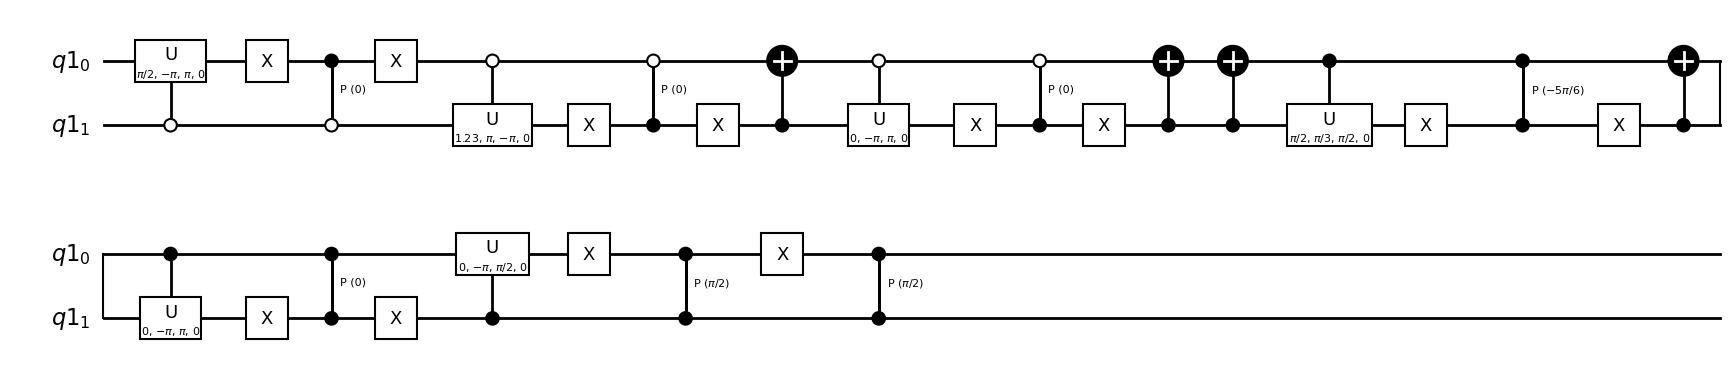

In [5]:
qr=QuantumRegister(2)
qc=QuantumCircuit(qr)
decomposer(f3i1, qc, qr)
qc.draw(output='mpl', style="bw")

In [6]:
#backend = Aer.get_backend('unitary_simulator')
#job = execute(qc, backend)
#u = np.asarray(job.result().get_unitary())
u = Operator(qc).data

print("Frobenius norm of difference between given unitary and result:",np.linalg.norm(f3i1-u))

Frobenius norm of difference between given unitary and result: 4.643148578483633e-16


#### Decompose the unitary of a random circuit

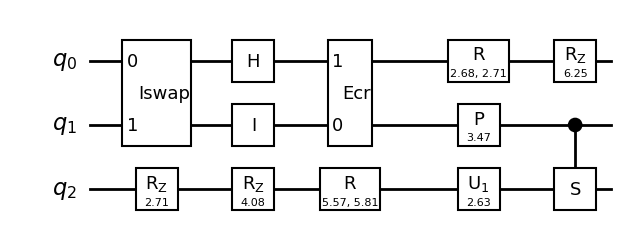

In [7]:
from qiskit.circuit.random import random_circuit
num_qubits=3
depth=5
qc=random_circuit(num_qubits, depth)
display(qc.draw(output='mpl', style="bw"))

# Get the unitary matrix that corresponds to this circuit.
#backend = Aer.get_backend('unitary_simulator')
#job = execute(qc, backend)
#uOriginal = np.asarray(job.result().get_unitary())

uOriginal = Operator(qc).data

In [8]:
qr=QuantumRegister(num_qubits)
qc=QuantumCircuit(qr)
decomposer(uOriginal, qc, qr)

# Get the unitary matrix that corresponds to this circuit.
#backend = Aer.get_backend('unitary_simulator')
#job = execute(qc, backend)
#uConstruct = np.asarray(job.result().get_unitary())
uConstruct = Operator(qc).data
#display(qc.decompose().draw(output='mpl', style="bw"))
print("Frobenius norm of difference between given unitary and result:",np.linalg.norm(uOriginal-uConstruct))

Frobenius norm of difference between given unitary and result: 2.980232239050853e-08


#### State preparation
- we can use the method ``circuitStateVector`` for creating a circuit for a unitary $U$
- the unitary $U^\dagger$ prepares the given state from the state $|0\rangle \otimes \ldots \otimes |0\rangle$

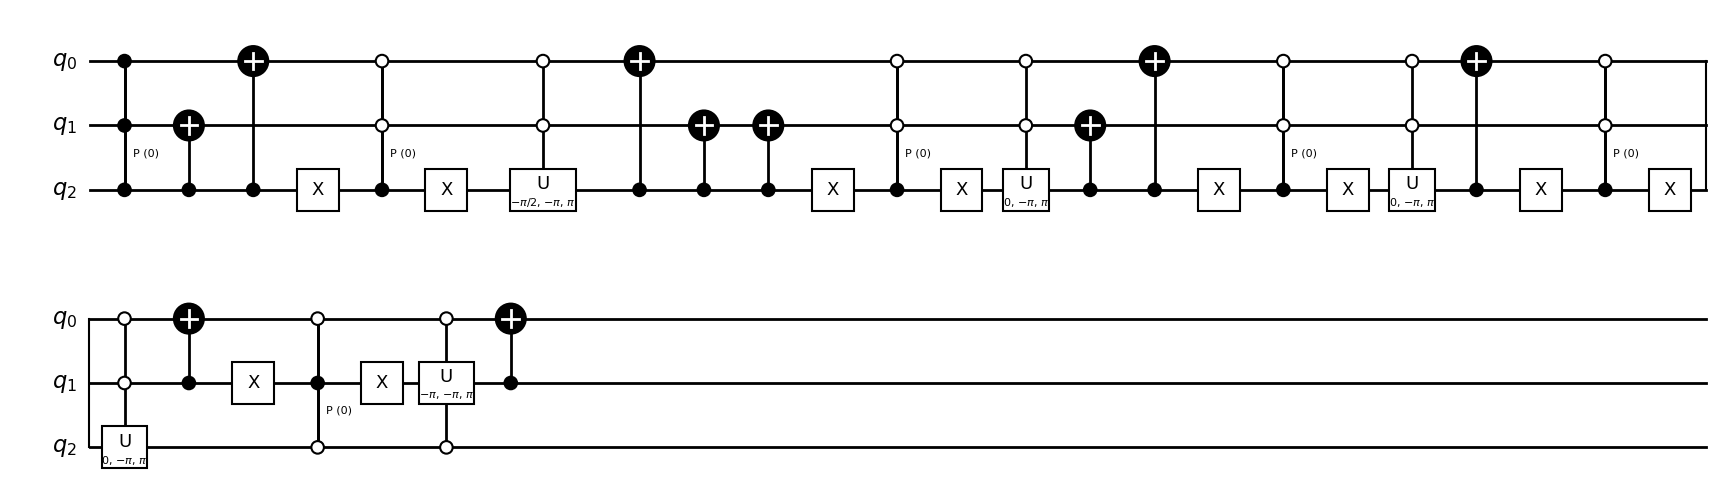

[ 1.11022302e-16+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  7.07106781e-01+8.65956056e-17j
 -2.29934717e-17+5.94451961e-34j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  7.07106781e-01+8.65956056e-17j]
Frobenius norm of difference between given state and constructed state: 2.004450070611106e-16


In [9]:
qubits=3
vOriginal=[0,0,0,1/math.sqrt(2),0,0,0,1/math.sqrt(2)]

# Create custom gate from unitary U.
qr=QuantumRegister(qubits,'q')
qc=QuantumCircuit(qr)
circuitStateVector(vOriginal,qc, qr)
gate=qc.to_gate()

# Apply U^dagger to create state v.
qr2=QuantumRegister(qubits,'q')
qc2=QuantumCircuit(qr2)
qc2.append(gate.inverse(),qr2)
display(qc2.decompose().draw(output='mpl', style="bw"))


#backend=Aer.get_backend('statevector_simulator')
#job=execute(qc2,backend)
#vReproduce=np.asarray(job.result().get_statevector())

vReproduce = Statevector(qc2).data
print(vReproduce)

print("Frobenius norm of difference between given state and constructed state:",np.linalg.norm(vOriginal-vReproduce))

the original vector: [(0.4758710130815074+0.4215270345019494j), (0.046316960567135294+0.3776177105660704j), (0.035503082865404954+0.4169564996253782j), (0.4744773523223823+0.2255646084468486j)]
qc2


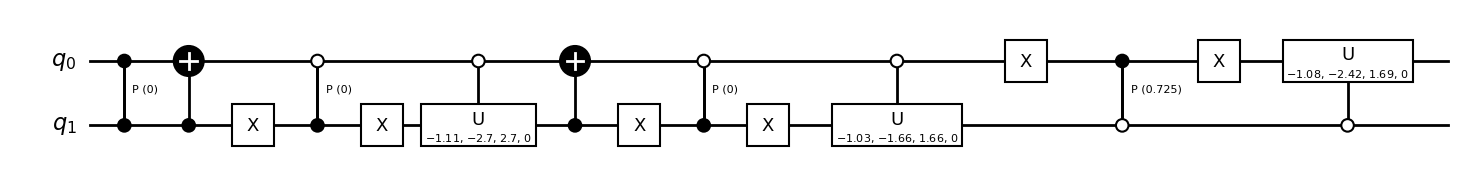

Frobenius norm of difference between given state and constructed state: 2.0407899217551515e-16


In [10]:
#
# Create circuit for a random state vector.
#
qubits=2
v=[random.random()+1j*random.random() for x in range(2**qubits)]
vNormed=[x/np.linalg.norm(v) for x in v]
print("the original vector:",vNormed)

# Create custom gate from unitary U
qr=QuantumRegister(qubits,'q')
qc=QuantumCircuit(qr)
circuitStateVector(vNormed,qc, qr)
gate=qc.to_gate()
#print("qc")
#display(qc.decompose().draw(output='mpl', style="bw"))

# Apply U^dagger to create state v.
qr2=QuantumRegister(qubits,'q')
qc2=QuantumCircuit(qr2)
qc2.append(gate.inverse(),qr2)

print("qc2")
display(qc2.decompose().draw(output='mpl', style="bw"))
#backend=Aer.get_backend('statevector_simulator')
#job=execute(qc2,backend)
#vReproduce=np.asarray(job.result().get_statevector())
vReproduce = Statevector(qc2).data

print("Frobenius norm of difference between given state and constructed state:",np.linalg.norm(vNormed-vReproduce))

#### Decomposition of a controlled X gate with simple recursive method with exponential overhead
- the method ``controlledXGate`` is a simple decomposition of an X gate with many control qubits into Toffoli gates
- the method needs an ancilla qubit
- the following circuit has the controlled X gate in the beginning and the full circuit should correspond to the identity

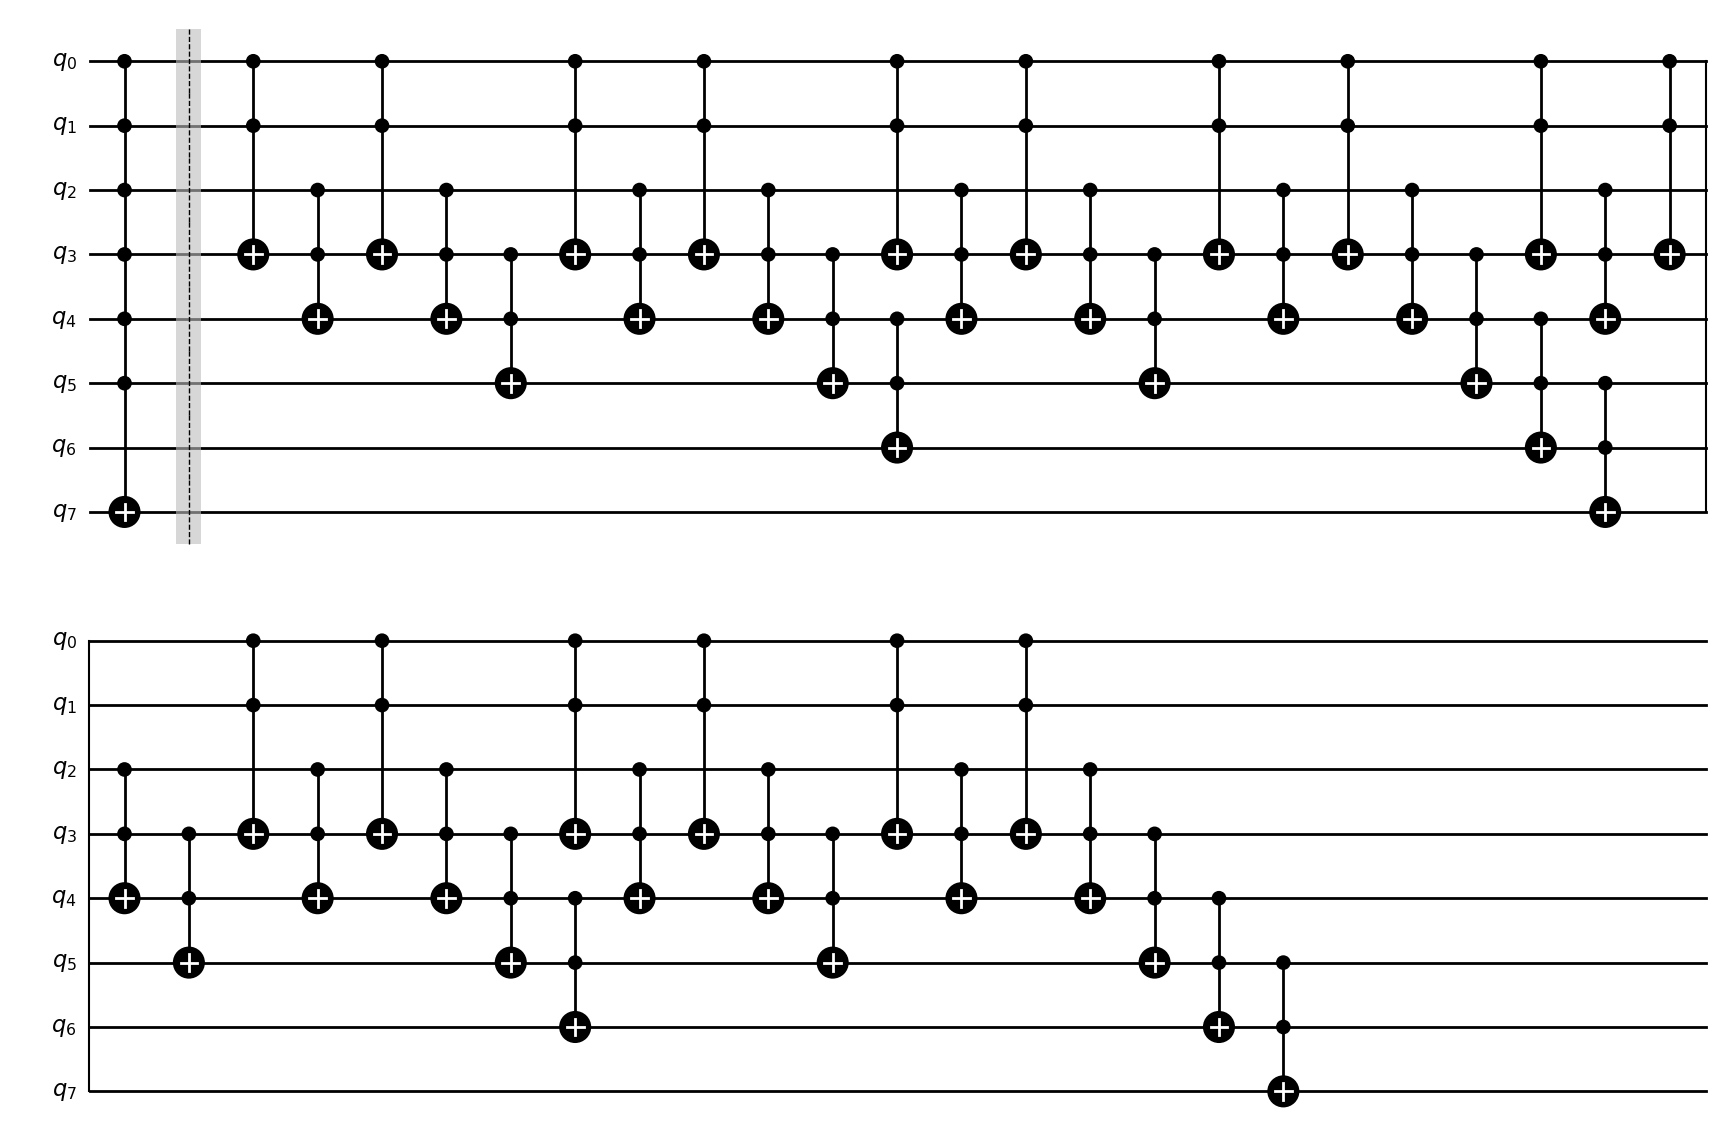

number of Toffoli gates: 46
Frobenius norm of difference between given identity and unitary of circuit: 7.718595526368431e-15


In [11]:
qubits=8
qr=QuantumRegister(qubits,'q')
qc=QuantumCircuit(qr)
qc.append(XGate().control(qubits-2),qr[:qubits-2]+[qr[qubits-1]])
qc.barrier()
controlledXGate(qr[:qubits-2], qr[qubits-2], qr[qubits-1], qc)
display(qc.draw(output='mpl', style="bw"))

# Verify that the total circuit is the identity.
#backend_sim = Aer.get_backend('unitary_simulator')
#job_sim = execute(qc, backend_sim)
#u=np.asarray(job_sim.result().get_unitary())
u = Operator(qc).data

error=np.linalg.norm(u-np.identity(2**qubits))

print("number of Toffoli gates:", len(qc)-2)
print("Frobenius norm of difference between given identity and unitary of circuit:",error)

#### Decomposition of a controlled X gate with linear overhead
- the method ``controlledXGateToffoliDecomposition`` implements corollary 7.4 of Barenco et. al.
- the method needs one ancilla qubit and it uses a number of Toffoli gates that is linear in the number of control qubits
- the following circuit has the controlled X gate in the beginning and the full circuit should correspond to the identity

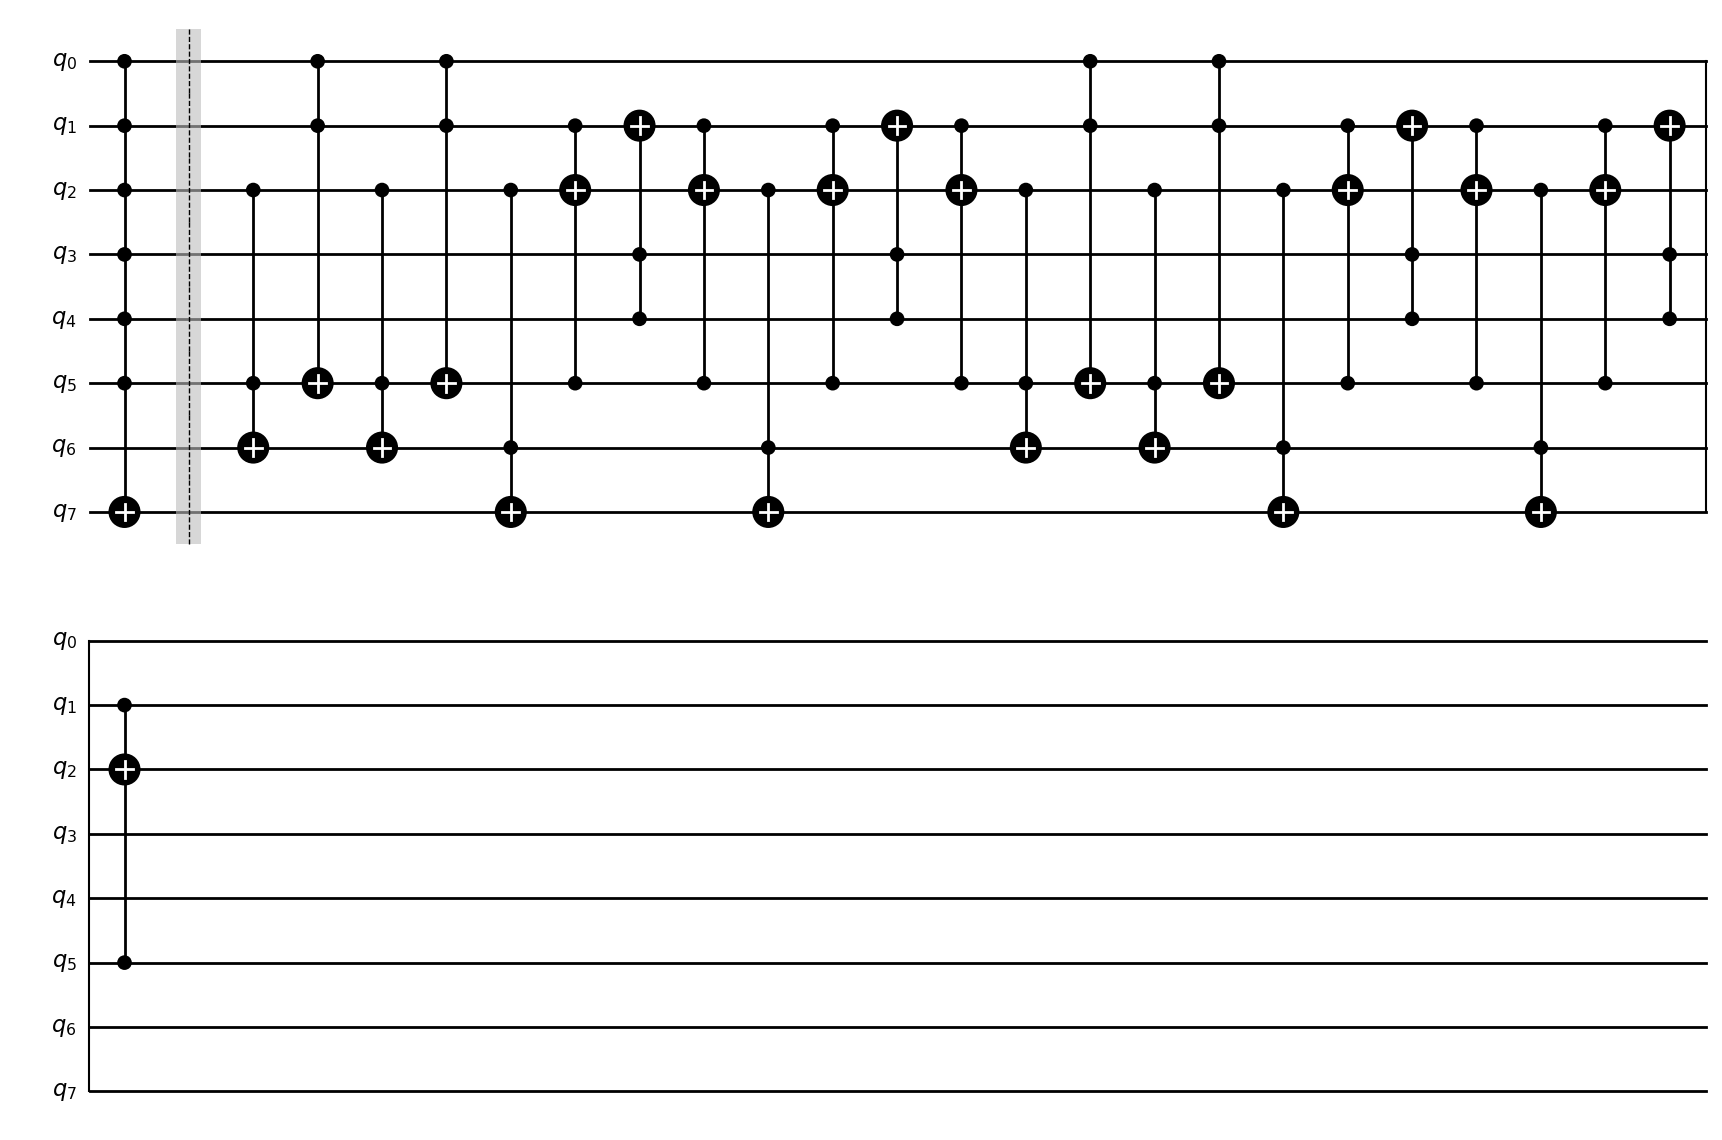

number of Toffoli gates: 24
Frobenius norm of difference between given identity and unitary of circuit: 7.718595526368431e-15


In [12]:
qubits=8
qr=QuantumRegister(qubits,'q')
qc=QuantumCircuit(qr)
qc.append(XGate().control(qubits-2),qr[:qubits-2]+[qr[qubits-1]])
qc.barrier()
controlledXGateToffoliDecomposition(qr[:qubits-2], qr[qubits-2], qr[qubits-1], qc)
display(qc.draw(output='mpl', style="bw"))

# Verify that the total circuit is the identity.
#backend_sim = Aer.get_backend('unitary_simulator')
#job_sim = execute(qc, backend_sim)
#u=np.asarray(job_sim.result().get_unitary())

u = Operator(qc).data
error=np.linalg.norm(u-np.identity(2**qubits))

print("number of Toffoli gates:", len(qc)-2)
print("Frobenius norm of difference between given identity and unitary of circuit:",error)

#### Comparison of both methods
- the number of Toffoli gates of the simple and the linear method are compared for a small number of control qubits

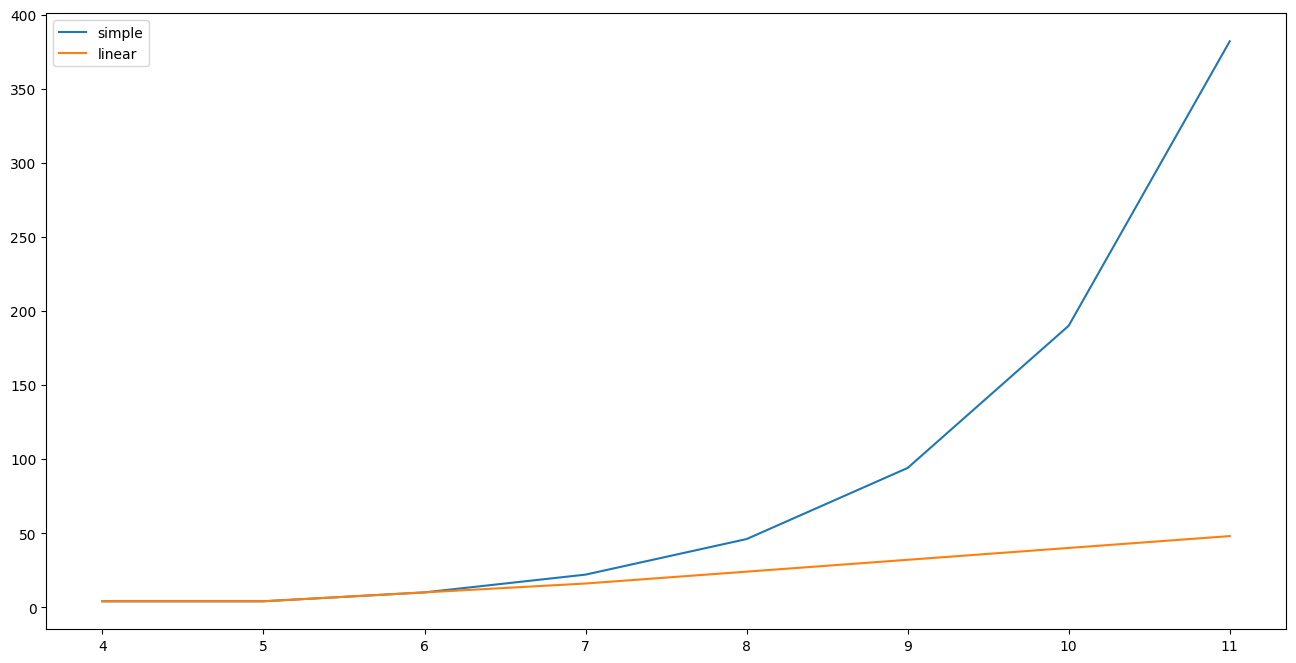

In [13]:
xeSimple=[]
yeSimple=[]
xeLinear=[]
yeLinear=[]
figure(figsize=(16, 8))

for qubits in range(4,12):
    qr=QuantumRegister(qubits,'q')
    qc=QuantumCircuit(qr)
    controlledXGate(qr[:qubits-2], qr[qubits-2], qr[qubits-1], qc)
    xeSimple.append(qubits)
    yeSimple.append(len(qc))
    
    qr=QuantumRegister(qubits,'q')
    qc=QuantumCircuit(qr)
    controlledXGateToffoliDecomposition(qr[:qubits-2], qr[qubits-2], qr[qubits-1], qc)
    xeLinear.append(qubits)
    yeLinear.append(len(qc))
    
plt.plot(xeSimple,yeSimple,label='simple')
plt.plot(xeLinear,yeLinear,label='linear')
plt.legend()